# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [2]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [3]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

32.700987254766929

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [4]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=d)
(X**2).sum(axis=1).mean()

23.296227192759808

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [7]:
def return_y(x):
    y = f(x) + np.random.uniform(low=-1,high=1,size=x.shape[0])
    return y

In [8]:
exp = np.random.exponential(size=sample_size)
y = return_y(exp)

In [9]:
from sklearn.tree import DecisionTreeRegressor

In [10]:
DTR = DecisionTreeRegressor()
DTR.fit(exp[:, np.newaxis], y[:, np.newaxis])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

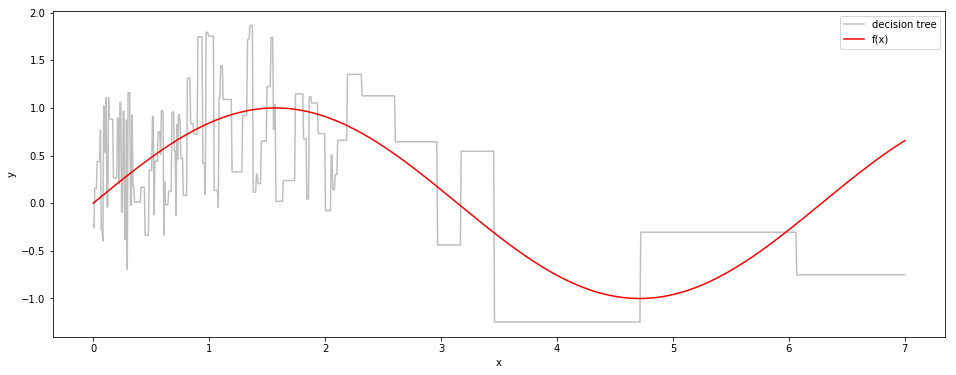

In [11]:
plt.figure(figsize=(16,6))
plt.plot(linspace, DTR.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5, label='decision tree')
plt.plot(linspace, f(linspace), color='red', label='f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

Усредненная зависимость - это RandomForest.

In [12]:
from sklearn.ensemble import RandomForestRegressor

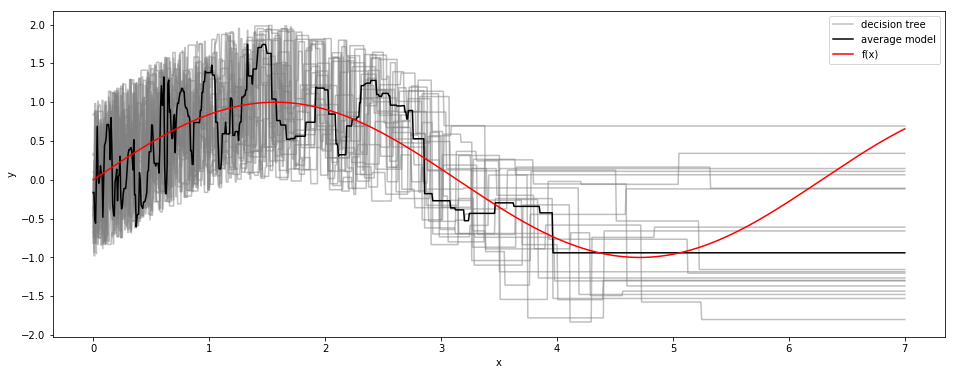

In [13]:
plt.figure(figsize=(16,6))

for i in range(samples_num-1):
    exp = np.random.exponential(size=sample_size)
    y = return_y(exp)
    DTR = DecisionTreeRegressor()
    DTR.fit(exp[:, np.newaxis], y[:, np.newaxis])
    plt.plot(linspace, DTR.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5)

exp = np.random.exponential(size=sample_size)
y = return_y(exp)
DTR = DecisionTreeRegressor()
DTR.fit(exp[:, np.newaxis], y[:, np.newaxis])
plt.plot(linspace, DTR.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5, label='decision tree')

RFR = RandomForestRegressor(n_estimators=samples_num, warm_start=True)
RFR.fit(exp[:, np.newaxis], y)
plt.plot(linspace, RFR.predict(linspace[:, np.newaxis]), color='black', label='average model')
plt.plot(linspace, f(linspace), color='red', label='f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

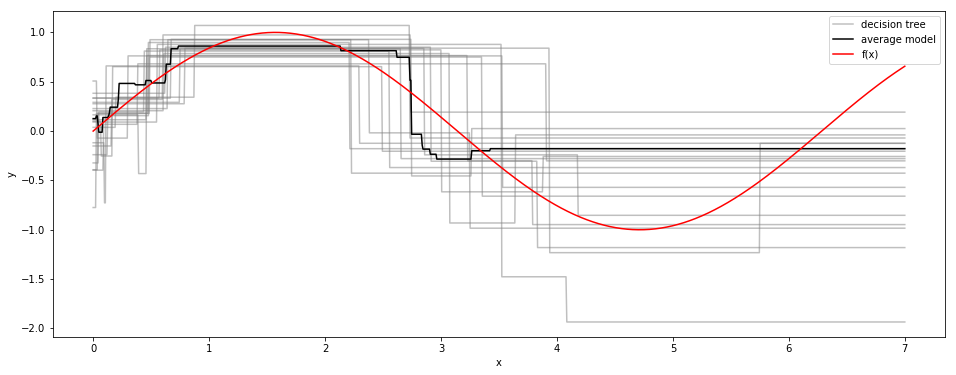

In [14]:
plt.figure(figsize=(16,6))

for i in range(samples_num-1):
    exp = np.random.exponential(size=sample_size)
    y = return_y(exp)
    DTR = DecisionTreeRegressor(max_depth=2)
    DTR.fit(exp[:, np.newaxis], y[:, np.newaxis])
    plt.plot(linspace, DTR.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5)

exp = np.random.exponential(size=sample_size)
y = return_y(exp)
DTR = DecisionTreeRegressor(max_depth=2)
DTR.fit(exp[:, np.newaxis], y[:, np.newaxis])
plt.plot(linspace, DTR.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5, label='decision tree')
    
RFR = RandomForestRegressor(n_estimators=samples_num, max_depth=2, warm_start=True)
RFR.fit(exp[:, np.newaxis], y)
plt.plot(linspace, RFR.predict(linspace[:, np.newaxis]), color='black', label='average model')
plt.plot(linspace, f(linspace), color='red', label='f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

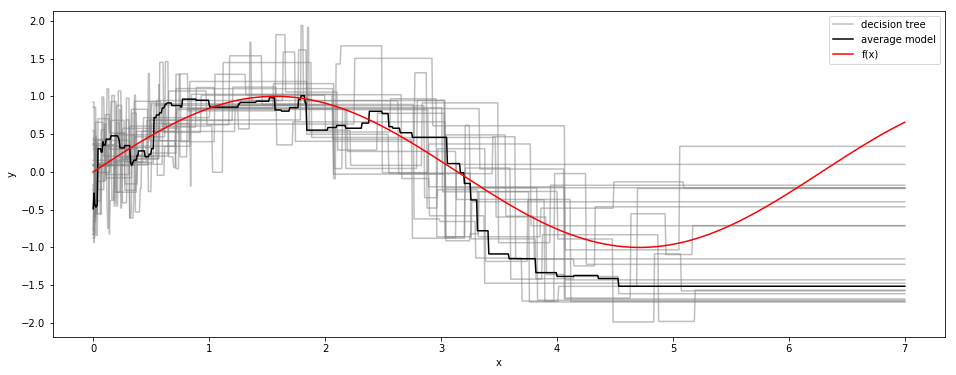

In [15]:
plt.figure(figsize=(16,6))

for i in range(samples_num):
    exp = np.random.exponential(size=sample_size)
    y = return_y(exp)
    DTR = DecisionTreeRegressor(max_depth=4)
    DTR.fit(exp[:, np.newaxis], y[:, np.newaxis])
    plt.plot(linspace, DTR.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5)

exp = np.random.exponential(size=sample_size)
y = return_y(exp)
DTR = DecisionTreeRegressor(max_depth=4)
DTR.fit(exp[:, np.newaxis], y[:, np.newaxis])
plt.plot(linspace, DTR.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5, label='decision tree')

RFR = RandomForestRegressor(n_estimators=samples_num, max_depth=4, warm_start=True)
RFR.fit(exp[:, np.newaxis], y)
plt.plot(linspace, RFR.predict(linspace[:, np.newaxis]), color='black', label='average model')
plt.plot(linspace, f(linspace), color='red', label='f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Чем меньше глубина, тем ниже смещение. В самом первом случае, когда мы использовали модель со стандартными параметрами, смещение близко к нулю, потому что там глубина деревьев выше.



__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

In [16]:
from sklearn.linear_model import LinearRegression

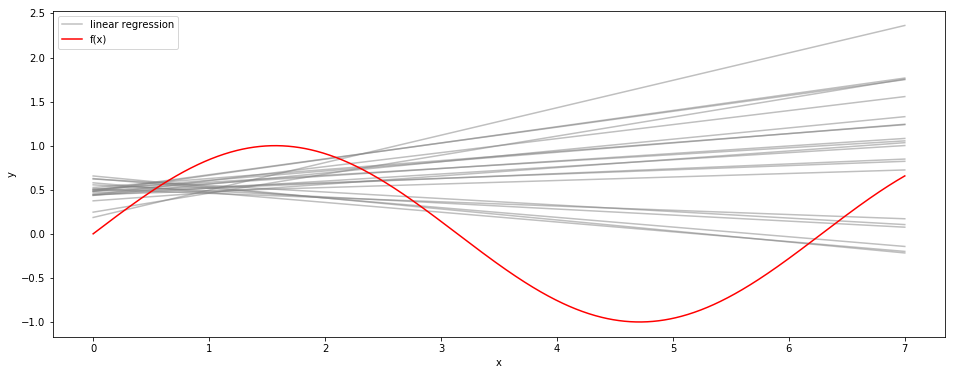

In [17]:
plt.figure(figsize=(16,6))

for i in range(samples_num):
    exp = np.random.exponential(size=sample_size)
    y = return_y(exp)
    LR = LinearRegression()
    LR.fit(exp[:, np.newaxis], y[:, np.newaxis])
    plt.plot(linspace, LR.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5)

exp = np.random.exponential(size=sample_size)
y = return_y(exp)
LR = LinearRegression()
LR.fit(exp[:, np.newaxis], y[:, np.newaxis])
plt.plot(linspace, LR.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5, label='linear regression')

plt.plot(linspace, f(linspace), color='red', label='f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

Линейная регрессия вообще плохо описывает исходную зависимость, что логично, поскольку синус не линеен.

In [18]:
from sklearn.svm import SVR

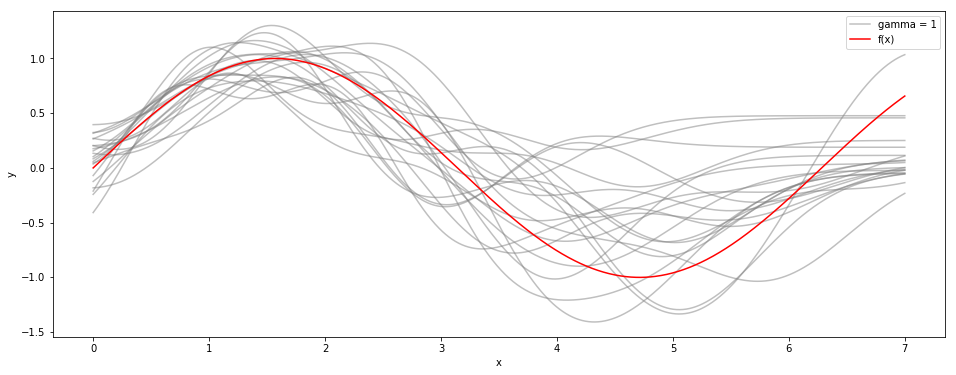

In [19]:
plt.figure(figsize=(16,6))

for i in range(samples_num):
    exp = np.random.exponential(size=sample_size)
    y = return_y(exp)
    RBF_1 = SVR(kernel='rbf', gamma=1)
    RBF_1.fit(exp[:, np.newaxis], y)
    plt.plot(linspace, RBF_1.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5)
    
exp = np.random.exponential(size=sample_size)
y = return_y(exp)
RBF_1 = SVR(kernel='rbf', gamma=1)
RBF_1.fit(exp[:, np.newaxis], y)
plt.plot(linspace, RBF_1.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5, label='gamma = 1')

plt.plot(linspace, f(linspace), color='red', label='f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

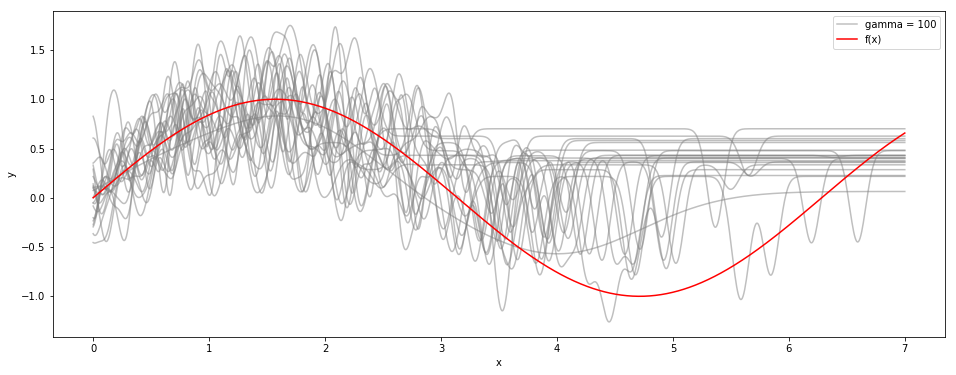

In [20]:
plt.figure(figsize=(16,6))

for i in range(samples_num):
    exp = np.random.exponential(size=sample_size)
    y = return_y(exp)
    RBF_100 = SVR(kernel='rbf', gamma=100)
    RBF_100.fit(exp[:, np.newaxis], y)
    plt.plot(linspace, RBF_100.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5)

exp = np.random.exponential(size=sample_size)
y = return_y(exp)
RBF_100 = SVR(kernel='rbf', gamma=1)
RBF_100.fit(exp[:, np.newaxis], y)
plt.plot(linspace, RBF_100.predict(linspace[:, np.newaxis]), color='gray', alpha=0.5, label='gamma = 100')

plt.plot(linspace, f(linspace), color='red', label='f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

SVM работает в данном случае лучше, чем линейная регрессия. SVM с gamma = 1 описывает синус лучше, чем SVM с gamma = 100. Значит gamma = 1 - более оптимальный параметр, чем gamma = 100.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

## Mushrooms
Датасет с грибами содержит только категориальные признаки.

In [22]:
mushrooms = pd.read_table('agaricus-lepiota.data', sep = ',', names=np.arange(23).tolist())
mushrooms.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [23]:
y = mushrooms.iloc[:,0]
X = mushrooms.iloc[:,1:]

y[y == 'p'] = 1
y[y == 'e'] = 0
y = np.asarray(y, dtype="|S6")

X = X.apply(LabelEncoder().fit_transform)
X.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1


In [24]:
y

array([b'1', b'0', b'0', ..., b'0', b'1', b'0'], 
      dtype='|S6')

In [25]:
cross_val_score(DecisionTreeClassifier(), X=X, y=y, scoring='accuracy', cv=10, n_jobs=-1)

array([ 0.68511685,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.93341554,  1.        ])

## Tic-tac-toe
Датасет с крестиками-ноликами тоже содержит только категориальные признаки.

In [26]:
tic_tac_toe = pd.read_table('tic-tac-toe.data', sep = ',', names=np.arange(10).tolist())
tic_tac_toe.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [27]:
y = tic_tac_toe.iloc[:,9]
X = tic_tac_toe.iloc[:,:9]

y[y == 'positive'] = 1
y[y == 'negative'] = 0
y = np.asarray(y, dtype="|S6")

X = X.apply(LabelEncoder().fit_transform)
X.head()

,0,1,2,3,4,5,6,7,8
0,2,2,2,2,1,1,2,1,1
1,2,2,2,2,1,1,1,2,1
2,2,2,2,2,1,1,1,1,2
3,2,2,2,2,1,1,1,0,0
4,2,2,2,2,1,1,0,1,0


In [28]:
cross_val_score(DecisionTreeClassifier(), X=X, y=y, scoring='accuracy', cv=10, n_jobs=-1)

array([ 0.72164948,  0.71134021,  0.51041667,  0.84375   ,  0.55208333,
        0.71875   ,  0.86315789,  0.83157895,  0.92631579,  0.91578947])

## Car

In [29]:
car = pd.read_table('car.data', sep = ',', names=np.arange(7).tolist())
car.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [30]:
car.iloc[:,2].unique()

array(['2', '3', '4', '5more'], dtype=object)

In [31]:
car.iloc[:,3].unique()

array(['2', '4', 'more'], dtype=object)

И в этом датасете только категориальные, поскольку нельзя считать вещественным признаком количество дверей, так как есть вариант больше 5 дверей.

In [32]:
y = car.iloc[:,6]
X = car.iloc[:,:6]

y[(y == 'unacc')|(y == 'acc')] = 0
y[(y == 'good')|(y == 'vgood')] = 1
y = np.asarray(y, dtype="|S6")

X = X.apply(LabelEncoder().fit_transform)
X.head()

,0,1,2,3,4,5
0,3,3,0,0,2,1
1,3,3,0,0,2,2
2,3,3,0,0,2,0
3,3,3,0,0,1,1
4,3,3,0,0,1,2


In [33]:
cross_val_score(DecisionTreeClassifier(), X=X, y=y, scoring='accuracy', cv=10, n_jobs=-1)

array([ 0.91954023,  0.94827586,  0.92528736,  0.97126437,  0.97093023,
        0.98837209,  0.91860465,  0.88372093,  0.93023256,  0.95348837])

## Nursery

In [34]:
nursery = pd.read_table('nursery.data', sep = ',', names=np.arange(9).tolist())
nursery.head()

,0,1,2,3,4,5,6,7,8
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [35]:
nursery.iloc[:,3].unique()

array(['1', '2', '3', 'more'], dtype=object)

In [36]:
nursery.iloc[:,8].unique()

array(['recommend', 'priority', 'not_recom', 'very_recom', 'spec_prior'], dtype=object)

Этот датасет тоже содержит только категориальные признаки.

In [37]:
y = nursery.iloc[:,8]
X = nursery.iloc[:,:7]

y[(y == 'not_recom')|(y == 'recommend')] = 0
y[(y == 'very_recom')|(y == 'priority')|(y == 'spec_prior')] = 1
y = np.asarray(y, dtype="|S6")

X = X.apply(LabelEncoder().fit_transform)
X.head()

,0,1,2,3,4,5,6
0,2,3,0,0,0,0,0
1,2,3,0,0,0,0,0
2,2,3,0,0,0,0,0
3,2,3,0,0,0,0,2
4,2,3,0,0,0,0,2


In [38]:
cross_val_score(DecisionTreeClassifier(), X=X, y=y, scoring='accuracy', cv=10, n_jobs=-1)

array([ 0.44410177,  0.66383963,  0.66358025,  0.66358025,  0.66512346,
        0.66512346,  0.66512346,  0.66435185,  0.66563707,  0.66640927])

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Поскольку в каждом из четырех датасетов все признаки являются категориальными, и нельзя даже некоторые из них представить в виде вещественных, мы не можем проанализировать, как решающие деревья работают на по-разному представленных датасетах. Если в первом вопросе имеется в виду, отличаются ли результаты решающих деревьев на каждом из датасетов, то, да, они действительно разные, ведь мы и анализируем различные датасеты.

Да, случайная компонента присутствует. Выражается она в том, что деревья строятся случайно. Конкретно в этом задании это незаметно, скорее всего потому что DecisionTreeClassifier() по умолчанию генерирует свой random_state. Возможно также, что cross_val_score всегда выбирает наиболее оптимальный набор деревьев.

Повлиять на это можно задав random_seed, при котором модель будет давать наибольшее качество. Если мы в целом говорим про DecisionTreeClassifier(), то там есть параметр random_state. 

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [82]:
wine = pd.read_csv('winequality-red.csv', sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [83]:
X = wine.drop('quality', axis = 1)
y = wine['quality']

In [84]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [85]:
cross_val_score(DecisionTreeClassifier(), X=X, y=y, scoring='accuracy', cv=3, n_jobs=-1)

array([ 0.44672897,  0.42964353,  0.46704331])

In [86]:
cross_val_score(BaggingClassifier(n_estimators=100), X=X, y=y, scoring='accuracy', cv=3, n_jobs=-1)

array([ 0.52149533,  0.57035647,  0.56873823])

In [87]:
cross_val_score(BaggingClassifier(n_estimators=100, max_samples=0.5), 
                X=X, y=y, scoring='accuracy', cv=3, n_jobs=-1)

array([ 0.54766355,  0.60412758,  0.60640301])

In [88]:
cross_val_score(RandomForestClassifier(n_estimators=100), X=X, y=y, scoring='accuracy', cv=3, n_jobs=-1)

array([ 0.53084112,  0.58536585,  0.59510358])

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [92]:
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [94]:
X_test.shape, X_train.shape

((480, 11), (1119, 11))

In [96]:
from sklearn.metrics import accuracy_score

Почему-то цикл работает гораздо быстрее кросс-валидации, поэтому им и воспользуемся:

In [98]:
%%time

all_estimators = np.linspace(100,5000,50).astype(int)

test_scores = []

for n_estimators in all_estimators:
    RFC = RandomForestClassifier(warm_start=True, n_jobs=-1, n_estimators=n_estimators)
    RFC.fit(X_train, y_train)
    test_score = accuracy_score(y_test, RFC.predict(X_test))
    test_scores.append(test_score)    

CPU times: user 6min 43s, sys: 48.8 s, total: 7min 32s
Wall time: 4min 16s


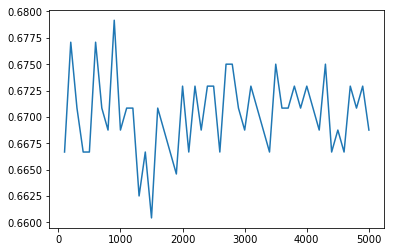

In [100]:
plt.plot(np.linspace(100,5000,50).astype(int), test_scores);

Судя по графику - нет, не переобучается. Даже нельзя сказать, что качаство однозначно растет, когда деревьев больше, что довольно странно.

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [92]:
from keras.datasets import mnist
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [93]:
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [159]:
from keras.models import Input, Model
from keras.layers import Dense, Flatten, Reshape

In [88]:
def create_dense_nn(object_size = 28, hidden_layers = [100,100], num_classes = 10, colour = 1):

    # Входной плейсхолдер
    inp = Input(shape=(object_size, object_size, colour))
    
    input_flat = Flatten()(inp)

    hid_1 = Dense(hidden_layers[0], activation='relu')(input_flat)
    hid_2 = Dense(hidden_layers[1], activation='relu')(hid_1)
    
    out = Dense(num_classes, activation='sigmoid')(hid_2)

    nn_100_100 = Model(input=inp, output=out, name="nn_100_100")
    
    return nn_100_100

In [89]:
nn_100_100 = create_dense_nn(object_size = 28, hidden_layers = [100,100] , colour = 1)

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="nn_100_100", inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


In [81]:
nn_100_100.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [84]:
nn_100_100.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
nn_100_100.fit(x_train, y_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 0.1177 - acc: 0.9659 - val_loss: 0.1293 - val_acc: 0.9614
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.1106 - acc: 0.9675 - val_loss: 0.1246 - val_acc: 0.9609
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.1062 - acc: 0.9683 - val_loss: 0.1215 - val_acc: 0.9616
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.1027 - acc: 0.9694 - val_loss: 0.1197 - val_acc: 0.9630
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.0996 - acc: 0.9699 - val_loss: 0.1184 - val_acc: 0.9632
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.0968 - acc: 0.9708 - val_loss: 0.1178 - val_acc: 0.9625
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.0942 - acc: 0.9716 - val_loss: 0.1139 - val_acc: 0.9644
Epoch 8/50
60000/60000 [==============================] - 1s 

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [153]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [156]:
def create_seq_1(input_shape = [28,28,1], num_classes = 10):
    nn_seq = Sequential()
    nn_seq.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    nn_seq.add(Conv2D(64, (3, 3), activation='relu'))
    nn_seq.add(MaxPooling2D(pool_size=(2, 2)))
    nn_seq.add(Flatten())
    nn_seq.add(Dense(128, activation='relu'))
    nn_seq.add(Dense(num_classes, activation='softmax'))
    return nn_seq

In [160]:
nn_seq = create_seq_1(input_shape = [28,28,1], num_classes = 10)

In [161]:
nn_seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
_________________________________________________________________


In [162]:
nn_seq.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [163]:
nn_seq.fit(x_train, y_train,
          batch_size=256,
          epochs=50,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 138s - loss: 0.2115 - acc: 0.9375 - val_loss: 0.0542 - val_acc: 0.9836
Epoch 2/50
60000/60000 [==============================] - 136s - loss: 0.0513 - acc: 0.9847 - val_loss: 0.0405 - val_acc: 0.9868
Epoch 3/50
60000/60000 [==============================] - 134s - loss: 0.0337 - acc: 0.9894 - val_loss: 0.0347 - val_acc: 0.9896
Epoch 4/50
60000/60000 [==============================] - 134s - loss: 0.0238 - acc: 0.9926 - val_loss: 0.0343 - val_acc: 0.9892
Epoch 5/50
60000/60000 [==============================] - 133s - loss: 0.0181 - acc: 0.9944 - val_loss: 0.0415 - val_acc: 0.9864
Epoch 6/50
60000/60000 [==============================] - 133s - loss: 0.0122 - acc: 0.9963 - val_loss: 0.0303 - val_acc: 0.9909
Epoch 7/50
60000/60000 [==============================] - 133s - loss: 0.0081 - acc: 0.9975 - val_loss: 0.0398 - val_acc: 0.9868
Epoch 8/50
60000/60000 [=======================

https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [164]:
def create_seq_2(input_shape = [28,28,1], num_classes = 10):
    nn_seq = Sequential()
    nn_seq.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    nn_seq.add(Conv2D(64, (3, 3), activation='relu'))
    nn_seq.add(MaxPooling2D(pool_size=(2, 2)))
    nn_seq.add(Dropout(0.25))
    nn_seq.add(Flatten())
    nn_seq.add(Dense(128, activation='relu'))
    nn_seq.add(Dropout(0.5))
    nn_seq.add(Dense(num_classes, activation='softmax'))
    return nn_seq

In [166]:
nn_seq2 = create_seq_2(input_shape = [28,28,1], num_classes = 10)

In [167]:
nn_seq2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [168]:
nn_seq2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [171]:
nn_seq2.fit(x_train, y_train,
          batch_size=256,
          epochs=50,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 146s - loss: 0.1378 - acc: 0.9593 - val_loss: 0.0496 - val_acc: 0.9836
Epoch 2/50
60000/60000 [==============================] - 143s - loss: 0.0828 - acc: 0.9755 - val_loss: 0.0392 - val_acc: 0.9865
Epoch 3/50
60000/60000 [==============================] - 143s - loss: 0.0625 - acc: 0.9811 - val_loss: 0.0342 - val_acc: 0.9880
Epoch 4/50
60000/60000 [==============================] - 148s - loss: 0.0529 - acc: 0.9838 - val_loss: 0.0297 - val_acc: 0.9891
Epoch 5/50
60000/60000 [==============================] - 139s - loss: 0.0450 - acc: 0.9861 - val_loss: 0.0305 - val_acc: 0.9890
Epoch 6/50
60000/60000 [==============================] - 141s - loss: 0.0398 - acc: 0.9875 - val_loss: 0.0277 - val_acc: 0.9910
Epoch 7/50
60000/60000 [==============================] - 142s - loss: 0.0342 - acc: 0.9890 - val_loss: 0.0298 - val_acc: 0.9906
Epoch 8/50
60000/60000 [=======================

Качество ниже, чем без дропаутов. Процесс обучения длится дольше.